In [25]:
%load_ext autoreload
%autoreload 2

Exercise description
--------------------

In the context of Mercadolibre's Marketplace an algorithm is needed to
predict if an item listed in the markeplace is new or used.

Your task to design a machine learning model to predict if an item is new or
used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k.jsonlines` and a
function to read that dataset in `build_dataset`.

For the evaluation you will have to choose an appropiate metric and also
elaborate an argument on why that metric was chosen.

The deliverables are:
- This file including all the code needed to define and evaluate a model.
- A text file with a short explanation on the criteria applied to choose the metric and the performance achieved on that metric.

In [83]:
# import libreries
import challenge_meli.utils.paths as path
from challenge_meli.utils.meli_utils import drop_missing_values
import json
import pandas as pd
import numpy as np

In [84]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open(path.data_raw_dir("MLA_100k.jsonlines"))]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

Even if we are advised that the data is fine, it is always a good to check the data and see how it behaves, and that helps us to understand the data so that we can suggest actions to take depending on the problem.

In [102]:
# read data
data =pd.read_json(path.data_raw_dir("MLA_100k.jsonlines"), lines=True).tail(10000)
# chack info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 90000 to 99999
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   seller_address                    10000 non-null  object             
 1   warranty                          3861 non-null   object             
 2   sub_status                        10000 non-null  object             
 3   condition                         10000 non-null  object             
 4   seller_contact                    237 non-null    object             
 5   deal_ids                          10000 non-null  object             
 6   base_price                        10000 non-null  float64            
 7   shipping                          10000 non-null  object             
 8   non_mercado_pago_payment_methods  10000 non-null  object             
 9   seller_id                         10000 non-null  int64  

In [103]:
# reset_index to create a id
data.reset_index(inplace=True)
data.sample(3)

,index,seller_address,warranty,sub_status,condition,seller_contact,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,...,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,geolocation,sold_quantity,available_quantity
8902,98902,"{'comment': '', 'longitude': -58.3954754, 'id'...",Sí,[],used,None,[],100.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",...,active,None,NaN,NaN,1,2015-10-02 14:47:19+00:00,http://articulo.mercadolibre.com.ar/MLA-582565...,"{'latitude': -34.5904488, 'longitude': -58.395...",0,1
1028,91028,"{'comment': '', 'longitude': -58.4338425, 'id'...",None,[],new,None,[],1490.0,"{'local_pick_up': True, 'methods': [], 'tags':...",[],...,active,None,NaN,NaN,1,2015-08-31 00:37:33+00:00,http://articulo.mercadolibre.com.ar/MLA-577072...,"{'latitude': -34.5756752, 'longitude': -58.433...",0,1
1688,91688,"{'comment': '', 'longitude': -58.4661542, 'id'...",None,[],used,None,[],60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Efectivo', 'id': 'MLAMO', 't...",...,active,None,NaN,NaN,1,2015-10-13 18:09:11+00:00,http://articulo.mercadolibre.com.ar/MLA-584454...,"{'latitude': -34.5699712, 'longitude': -58.466...",0,1


In [104]:
# see the distribution of the numerical columns
data.describe()

,index,base_price,seller_id,price,official_store_id,differential_pricing,original_price,catalog_product_id,subtitle,initial_quantity,sold_quantity,available_quantity
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,73.000000,0.0,13.000000,4.000000e+00,0.0,10000.000000,10000.000000,10000.000000
mean,94999.50000,4.921612e+03,8.421223e+07,4.921618e+03,213.945205,NaN,2601.538462,5.183544e+06,NaN,36.319100,3.017500,36.116900
std,2886.89568,3.837989e+04,5.477952e+07,3.837989e+04,122.955942,NaN,4169.966139,1.675771e+05,NaN,420.953163,88.963774,420.797598
min,90000.00000,1.000000e+00,5.857000e+03,1.000000e+00,14.000000,NaN,350.000000,5.093232e+06,NaN,1.000000,0.000000,1.000000
25%,92499.75000,9.292500e+01,4.008454e+07,9.292500e+01,114.000000,NaN,599.000000,5.093232e+06,NaN,1.000000,0.000000,1.000000
50%,94999.50000,2.500000e+02,7.634844e+07,2.500000e+02,238.000000,NaN,889.000000,5.103216e+06,NaN,1.000000,0.000000,1.000000
75%,97499.25000,8.759825e+02,1.317668e+08,8.759825e+02,296.000000,NaN,1225.000000,5.193528e+06,NaN,2.000000,0.000000,2.000000
max,99999.00000,1.499000e+06,1.946906e+08,1.499000e+06,444.000000,NaN,13999.000000,5.434513e+06,NaN,9999.000000,8676.000000,9999.000000


We observe that the DataFrame has columns with NaN, dictionaries and lists that seem empty, to confirm the quality and integrity of our data we will see the amount of Nan per column and we will also see how much information there is in these columns with lists and dictionaries.

In [105]:
# how many columns have Nan data?
data.isna().sum()

index                                   0
seller_address                          0
warranty                             6139
sub_status                              0
condition                               0
seller_contact                       9763
deal_ids                                0
base_price                              0
shipping                                0
non_mercado_pago_payment_methods        0
seller_id                               0
variations                              0
location                                0
site_id                                 0
listing_type_id                         0
price                                   0
attributes                              0
buying_mode                             0
tags                                    0
listing_source                          0
parent_item_id                       2321
coverage_areas                          0
category_id                             0
descriptions                      

In [106]:
# we eliminate the columns that have more than 70% of the data with NaN values.
data = drop_missing_values(data, 70.0)

data.shape

(10000, 42)

# Correction Dict and List

In [107]:
dict_list_cols = [col for col in data.columns if data[col].apply(lambda x: type(x) in [list, dict]).any()]

In [108]:
dict_list_cols

['seller_address',
 'sub_status',
 'deal_ids',
 'shipping',
 'non_mercado_pago_payment_methods',
 'variations',
 'location',
 'attributes',
 'tags',
 'coverage_areas',
 'descriptions',
 'pictures',
 'geolocation']

In [109]:
data[dict_list_cols].sample(3)

,seller_address,sub_status,deal_ids,shipping,non_mercado_pago_payment_methods,variations,location,attributes,tags,coverage_areas,descriptions,pictures,geolocation
2890,"{'comment': '', 'longitude': -58.3684913, 'id'...",[],[],"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Acordar con el comprador', '...",[],{},[],[dragged_bids_and_visits],[],[{'id': 'MLA577160789-907964989'}],"[{'size': '332x500', 'secure_url': 'https://a2...","{'latitude': -34.630268, 'longitude': -58.3684..."
4362,"{'comment': '', 'longitude': -58.5862979, 'id'...",[],[],"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",[],{},"[{'value_id': '611eef5', 'attribute_group_id':...",[dragged_bids_and_visits],[],[{'id': 'MLA579489812-920295713'}],"[{'size': '500x375', 'secure_url': 'https://a2...","{'latitude': -34.4257507, 'longitude': -58.586..."
3415,"{'comment': '', 'longitude': -58.4603033, 'id'...",[],[],"{'local_pick_up': True, 'methods': [], 'tags':...",[],[],{},[],[],[],[{'id': 'MLA578167251-913467112'}],[],"{'latitude': -34.5585045, 'longitude': -58.460..."


In [110]:
def check_cols_with_list(data):
    dict_list_cols = [col for col in data.columns if data[col].apply(lambda x: type(x) in [list, dict]).any()]
    drop_cols = []
    for col in dict_list_cols:
        exist_values = data[col].apply(lambda x: 0 if not x else 1)
        if sum(exist_values)<=8000:
            drop_cols.append(col)
    data.drop(columns=drop_cols,inplace=True)
    return data

In [111]:
# we extract the names of the columns that are empty exceeding 80%
data = check_cols_with_list(data)

In [112]:
# check dimentions
data.shape

(10000, 34)

With the previous cleaning we try not to introduce noise or columns that do not provide relevant information to the model. Then what we will do is to extract the dictionaries that are embedded in the columns and create new columns with this description.

In [113]:
# cols with dict
dict_cols = [col for col in data.columns if data[col].apply(lambda x: type(x) in [dict]).any()]

In [114]:
data[dict_cols].sample(3)

,seller_address,shipping,geolocation
7735,"{'comment': '', 'longitude': -58.7016082, 'id'...","{'local_pick_up': True, 'methods': [], 'tags':...","{'latitude': -34.6725165, 'longitude': -58.701..."
3623,"{'comment': '', 'longitude': -58.4401546, 'id'...","{'local_pick_up': True, 'methods': [], 'tags':...","{'latitude': -34.5900151, 'longitude': -58.440..."
9157,"{'comment': '', 'longitude': -58.4397823, 'id'...","{'local_pick_up': True, 'methods': [], 'tags':...","{'latitude': -34.6049013, 'longitude': -58.439..."


we are going to flatten the columns with dictionary to make an augmented data type, however there are elements that come empty, which implies doing a cleanup again.

In [115]:
# flatten columns
df_dict = pd.DataFrame()
for col in dict_cols:
    # read JSON 
    json_open = data[col].apply(lambda x: json.dumps(x))
    # flatend json and add as new column
    df = pd.json_normalize(json_open.apply(json.loads)).add_prefix(col + '_')
    df.replace(to_replace=[''], value=np.nan, inplace=True)
    df_dict = pd.concat([df_dict, df], axis=1)
    # delete current column
    data.drop(columns=[col], inplace=True)

# show
df_dict.head(3)

,seller_address_comment,seller_address_longitude,seller_address_id,seller_address_address_line,seller_address_latitude,seller_address_zip_code,seller_address_country.name,seller_address_country.id,seller_address_search_location.neighborhood.name,seller_address_search_location.neighborhood.id,...,seller_address_state.id,shipping_local_pick_up,shipping_methods,shipping_tags,shipping_free_shipping,shipping_mode,shipping_dimensions,shipping_free_methods,geolocation_latitude,geolocation_longitude
0,NaN,-58.948749,55994382.0,NaN,-34.610683,NaN,Argentina,AR,NaN,NaN,...,AR-B,True,[],[],False,custom,None,NaN,-34.610683,-58.948749
1,NaN,-58.381593,145462548.0,NaN,-34.603723,NaN,Argentina,AR,NaN,NaN,...,AR-C,False,[],[],False,not_specified,None,NaN,-34.603723,-58.381593
2,NaN,-58.631727,61091255.0,NaN,-34.692066,NaN,Argentina,AR,NaN,NaN,...,AR-B,False,[],[],False,me2,None,NaN,-34.692066,-58.631727


In [116]:
# Delete column with 70% or more of nan
df_dict = drop_missing_values(df_dict, 70.0)

In [117]:
df_dict.shape

(10000, 22)

We must confirm if when flattening the json new list or dict columns were generated and also confirm if they have relevant information.

In [118]:
df_dict = check_cols_with_list(df_dict)

In [119]:
df_dict.shape

(10000, 20)

In [120]:
#join the new columns to dataframe
data = pd.concat([data, df_dict], axis=1)
data

,index,warranty,condition,base_price,seller_id,site_id,listing_type_id,price,buying_mode,listing_source,...,seller_address_search_location.city.id,seller_address_city.name,seller_address_city.id,seller_address_state.name,seller_address_state.id,shipping_local_pick_up,shipping_free_shipping,shipping_mode,geolocation_latitude,geolocation_longitude
0,90000,None,used,6700.0,99151748,MLA,silver,6700.0,buy_it_now,,...,TUxBQ0dFTjY4NTg,General Rodríguez,TUxBQ0dFTjY4NTg,Buenos Aires,AR-B,True,False,custom,-34.610683,-58.948749
1,90001,Sí,new,119.0,65545512,MLA,bronze,119.0,buy_it_now,,...,TUxBQ0NBUGZlZG1sYQ,MICROCENTRO,NaN,Capital Federal,AR-C,False,False,not_specified,-34.603723,-58.381593
2,90002,Sí,new,450.0,101563090,MLA,bronze,450.0,buy_it_now,,...,TUxBQ01PUmI1NTBj,Morón,TUxBQ01PUmI1NTBj,Buenos Aires,AR-B,False,False,me2,-34.692066,-58.631727
3,90003,Sí,used,40.0,48581930,MLA,bronze,40.0,buy_it_now,,...,TUxBQ1NBTjg4ZmJk,acassuso,NaN,Buenos Aires,AR-B,True,False,me2,-34.484991,-58.510280
4,90004,None,new,30.0,39469568,MLA,bronze,30.0,buy_it_now,,...,TUxBQ0NBUGZlZG1sYQ,Palermo,TUxBQlBBTDI1MTVa,Capital Federal,AR-C,True,False,not_specified,-34.582632,-58.425424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,99995,None,used,30.0,86277472,MLA,free,30.0,buy_it_now,,...,NaN,Don Torcuato,NaN,Buenos Aires,AR-B,True,False,me2,-34.489321,-58.614289
9996,99996,None,new,239.0,120301324,MLA,bronze,239.0,buy_it_now,,...,TUxBQ0xPTWMwNjk3,Lomas de Zamora,TUxBQ0xPTWMwNjk3,Buenos Aires,AR-B,False,False,not_specified,NaN,NaN
9997,99997,None,used,600.0,12147240,MLA,bronze,600.0,buy_it_now,,...,TUxBQ01PUmI1NTBj,Morón,TUxBQ01PUmI1NTBj,Buenos Aires,AR-B,False,False,me2,-34.646786,-58.624120
9998,99998,"Buen estado, se verifica al entregar. la total...",used,50.0,86102489,MLA,bronze,50.0,buy_it_now,,...,TUxBQ0NBUGZlZG1sYQ,Balvanera,TUxBQkJBTDMxMDZa,Capital Federal,AR-C,True,False,me2,-34.610009,-58.402037


# Column processing with list

In [125]:
# listamos la columnas tipo dict o list
list_cols = [col for col in data.columns if data[col].apply(lambda x: type(x) in [list]).any()]

In [126]:
list_cols

['descriptions', 'pictures']

In [127]:
data['descriptions'].sample(3)

7289    [{'id': 'MLA584024027-941981454'}]
7830    [{'id': 'MLA583454732-939558592'}]
5154                                    []
Name: descriptions, dtype: object

In [128]:
data.id[[904,5537,3224]]

904     MLA580118362
5537    MLA581073325
3224    MLA576259083
Name: id, dtype: object

In [129]:
data.drop(columns='descriptions', inplace=True)

We eliminate the description column because it is already contained in the id column and it would be a duplicate column.

We need explore the pictures column

In [130]:
data['pictures']

0       [{'size': '500x375', 'secure_url': 'https://a2...
1       [{'size': '500x375', 'secure_url': 'https://a2...
2       [{'size': '312x308', 'secure_url': 'https://a2...
3       [{'size': '375x500', 'secure_url': 'https://a2...
4       [{'size': '396x500', 'secure_url': 'https://a2...
                              ...                        
9995    [{'size': '500x375', 'secure_url': 'https://a2...
9996    [{'size': '500x375', 'secure_url': 'https://a2...
9997    [{'size': '500x375', 'secure_url': 'https://a2...
9998    [{'size': '387x500', 'secure_url': 'https://a2...
9999    [{'size': '375x500', 'secure_url': 'https://a2...
Name: pictures, Length: 10000, dtype: object

In [131]:
# we create one dataframe per row in the pictures column
temp = pd.DataFrame()
for row in range(0,10000):
    if not data['pictures'].iloc[row]:
        pictures = pd.DataFrame(np.nan, index=[0], columns=['pictures_size', 'pictures_secure_url', 'pictures_max_size','pictures_url', 'pictures_quality', 'pictures_id'])
        pictures['index'] = data['index'].iloc[row]
        temp = pd.concat([temp, pictures],ignore_index=True)
    else:
        pictures = pd.DataFrame(data['pictures'].iloc[row]).add_prefix('pictures' + '_').drop_duplicates()
        pictures['index'] = data['index'].iloc[row]
        temp = pd.concat([temp, pictures],ignore_index=True)
# temp.dropna(inplace=True)

In [132]:
temp.shape

(29493, 7)

In [133]:
# we delete the picture column
data.drop(columns='pictures', inplace=True)

In [134]:
# join the dataframes by index
data = data.set_index('index').join(temp.set_index('index'), how='inner')

In [135]:
# save data a CSV file
data.to_csv(path.data_processed_dir('data_raw.csv'), index=False)

We now have a dataset ready to search and do some kind of analysis to see if the variables are relevant to the new or used item classification.

# examination of the dataset and understanding of the variables

In [1]:
# import libraries
import challenge_meli.utils.paths as path
from challenge_meli.utils.meli_utils import check_quality,drop_missing_values
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(path.data_processed_dir('data_raw.csv'),low_memory=False)

In [3]:
data = drop_missing_values(data, 50)

the date_created is the variable when the article was created

In [4]:
data['date_created']

0        2015-09-08T21:17:57.000Z
1        2015-09-08T21:17:57.000Z
2        2015-09-08T21:17:57.000Z
3        2015-09-08T21:17:57.000Z
4        2015-09-08T21:17:57.000Z
                   ...           
29489    2015-09-06T22:29:30.000Z
29490    2015-08-18T17:22:28.000Z
29491    2015-09-21T13:02:16.000Z
29492    2015-09-21T13:02:16.000Z
29493    2015-09-21T13:02:16.000Z
Name: date_created, Length: 29494, dtype: object

In [5]:
#transform the date format
cols_date = ['date_created','last_updated']
for col in cols_date:
    data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')

In [6]:
# extract information and create new columns
data['Year_created']=data['date_created'].dt.year
data['Month_created']=data['date_created'].dt.month_name()
data['day_name_created']=data['date_created'].dt.day_name()
data['Hour_created']=data['date_created'].dt.hour
data['Min_created']=data['date_created'].dt.minute

data['Year_updated']=data['last_updated'].dt.year
data['Month_updated']=data['last_updated'].dt.month_name()
data['day_name_updated']=data['last_updated'].dt.day_name()
data['Hour_updated']=data['last_updated'].dt.hour
data['Min_updated']=data['last_updated'].dt.minute

We need to check the quality of new data

In [7]:
data['Year_created'].value_counts()

2015.0    29376
2014.0      111
2013.0        6
Name: Year_created, dtype: int64

In [8]:
data = data[data['Year_created']!=2013]

In [9]:
data['Month_created'].value_counts()

September    14103
October       8181
August        6775
July           155
November        70
February        51
December        39
January         35
June            32
May             26
March           14
April            6
Name: Month_created, dtype: int64

In [10]:
data = data[~data['Month_created'].isin(['March','April'])]

In [11]:
data['Month_updated'].value_counts()

October      13149
September    12587
August        3698
November        24
June             9
Name: Month_updated, dtype: int64

In [12]:
data = data[~data['Month_updated'].isin(['June','November'])]

In [13]:
data['Year_updated'].value_counts()

2015.0    29434
Name: Year_updated, dtype: int64

delete all the time variables, 'start_time', 'stop_time', should we confirm if it is the article submission and has no relation with the created article? however I will assume so

In [14]:
data.drop(columns=['date_created','last_updated','start_time','stop_time','Year_updated'], inplace=True)

In [15]:
check_quality(data)

Valores NA por columna:
condition                                     0.003397
base_price                                    0.003397
seller_id                                     0.003397
site_id                                       0.003397
listing_type_id                               0.003397
price                                         0.003397
buying_mode                                   0.003397
parent_item_id                               25.449295
category_id                                   0.003397
international_delivery_mode                   0.003397
id                                            0.003397
accepts_mercadopago                           0.003397
currency_id                                   0.003397
thumbnail                                     0.295567
title                                         0.003397
automatic_relist                              0.003397
secure_thumbnail                              0.295567
status                                   

the following columns will be removed because they do not add relevant information to the classification model:
- 'geolocation_latitude','geolocation_longitude' = its duplicated and have more null values.
- base_price' = it duplicated with price.
- 'initial_quantity','sold_quantity','available_quantity' = the item quantity should not influence the creation of a new item.
- Columns have only one category = 'site_id','international_delivery_mode','seller_address_country.name','seller_address_country.id','seller_address_search_location.state.name','seller_address_search_location.city.name'.

In [16]:
drop_cols = ['geolocation_latitude','geolocation_longitude','base_price','initial_quantity','sold_quantity','available_quantity','site_id','international_delivery_mode','seller_address_country.name','seller_address_country.id','seller_address_search_location.state.name','seller_address_search_location.city.name']

In [17]:
data.drop(columns=drop_cols, inplace=True)

In [18]:
# we check the distribution data
data.describe()

,seller_id,price,seller_address_longitude,seller_address_id,seller_address_latitude,Year_created,Hour_created,Min_created,Hour_updated,Min_updated
count,2.943400e+04,2.943400e+04,27421.000000,2.941800e+04,27405.000000,29434.000000,29434.000000,29434.00000,29434.000000,29434.000000
mean,8.630885e+07,1.136467e+04,-58.703394,1.149287e+08,-34.360528,2014.997044,13.746212,29.56129,13.698206,29.295780
std,5.571873e+07,6.588620e+04,4.636144,3.832110e+07,3.343576,0.054287,6.940193,17.18061,6.977114,17.435043
min,5.857000e+03,1.000000e+00,-101.690433,3.811880e+05,-54.819500,2014.000000,0.000000,0.00000,0.000000,0.000000
25%,3.974296e+07,1.200000e+02,-58.533275,8.173757e+07,-34.643010,2015.000000,11.000000,15.00000,11.000000,14.000000
50%,7.811787e+07,3.790000e+02,-58.454572,1.198866e+08,-34.604526,2015.000000,15.000000,30.00000,15.000000,29.000000
75%,1.368561e+08,1.459750e+03,-58.390200,1.494673e+08,-34.577469,2015.000000,19.000000,44.00000,19.000000,45.000000
max,1.946906e+08,1.499000e+06,0.000000,1.709611e+08,22.143825,2015.000000,23.000000,59.00000,23.000000,59.000000


In [19]:
data.dropna(inplace=True)

In [20]:
id_cols = [col for col in data.columns if 'id' in col]
data[id_cols].sample(5)

,seller_id,listing_type_id,parent_item_id,category_id,id,currency_id,seller_address_id,seller_address_search_location.state.id,seller_address_search_location.city.id,seller_address_state.id,pictures_id
21865,89853370.0,bronze,MLA565657759,MLA3032,MLA575323743,ARS,112778562.0,TUxBUENBUGw3M2E1,TUxBQ0NBUGZlZG1sYQ,AR-C,11859-MLA20051015646_022014
698,163223881.0,free,MLA569212624,MLA372532,MLA579766658,ARS,147916997.0,TUxBUFpPTmFpbnRl,TUxBQ1NBTjExMTU,AR-B,463501-MLA20344018341_072015
20832,22164343.0,free,MLA571821933,MLA31797,MLA581752179,ARS,86124745.0,TUxBUFNBTmU5Nzk2,TUxBQ1JPUzg1Yjg3,AR-S,134301-MLA20311199528_052015
14173,32902820.0,bronze,MLA570287181,MLA16350,MLA580247000,ARS,11783663.0,TUxBUENBUGw3M2E1,TUxBQ0NBUGZlZG1sYQ,AR-C,961401-MLA20305035856_052015
9996,62435185.0,gold_special,MLA565417096,MLA60614,MLA574990183,ARS,56282551.0,TUxBUENBUGw3M2E1,TUxBQ0NBUGZlZG1sYQ,AR-C,17899-MLA6799881761_082014


In [21]:
data.groupby(['seller_id','parent_item_id','category_id','id','pictures_id'])['condition'].size().reset_index().sort_values('condition')

,seller_id,parent_item_id,category_id,id,pictures_id,condition
0,39092.0,MLA565292197,MLA41173,MLA574849399,19909-MLA20181204291_102014,1
13344,98652717.0,MLA566707567,MLA41146,MLA576458374,7923-MLA20000022067_102013,1
13343,98652717.0,MLA565658257,MLA40497,MLA575395189,3921-MLA4887059662_082013,1
13342,98646123.0,MLA568233617,MLA2458,MLA577949905,4540-MLA3703583042_012013,1
13341,98646123.0,MLA568233617,MLA2458,MLA577949905,4533-MLA3703583984_012013,1
...,...,...,...,...,...,...
6668,49196535.0,MLA572386678,MLA30029,MLA582719582,4044-MLA120058136_6502,1
6667,49196535.0,MLA572386678,MLA30029,MLA582719582,4009-MLA120058136_7750,1
6666,49169205.0,MLA582557183,MLA64245,MLA584560014,294401-MLA20334704570_072015,1
6673,49205823.0,MLA565866075,MLA86029,MLA575559657,16186-MLA20116392429_062014,1


In [22]:
address_cols = [col for col in data.columns if 'address' in col]
data[address_cols].sample(5)

,seller_address_longitude,seller_address_id,seller_address_latitude,seller_address_search_location.state.id,seller_address_search_location.city.id,seller_address_city.name,seller_address_state.name,seller_address_state.id
14948,-58.665974,73005195.0,-34.655596,TUxBUEdSQWVmNTVm,TUxBQ0lUVTNjNDFm,Ituzaingó,Buenos Aires,AR-B
4879,-58.450000,163599686.0,-34.616667,TUxBUENBUGw3M2E1,TUxBQ0NBUGZlZG1sYQ,Caballito,Capital Federal,AR-C
29089,-58.402675,153144645.0,-34.695038,TUxBUEdSQXJlMDNm,TUxBQ0FWRTc5OTQ1,Avellaneda,Buenos Aires,AR-B
21866,-58.386364,112778562.0,-34.616681,TUxBUENBUGw3M2E1,TUxBQ0NBUGZlZG1sYQ,ciudad de buenos aires,Capital Federal,AR-C
10418,-58.436024,146744307.0,-34.586340,TUxBUENBUGw3M2E1,TUxBQ0NBUGZlZG1sYQ,Palermo,Capital Federal,AR-C


In [23]:
sizes = data['pictures_size'].apply(lambda x: x.split('x'))
data['row_size'] = [item[0] for item in sizes]
data['col_size'] = [item[1] for item in sizes]

In [24]:
sizes = data['pictures_max_size'].apply(lambda x: x.split('x'))
data['row_max_size'] = [item[0] for item in sizes]
data['col_max_size'] = [item[1] for item in sizes]

In [25]:
data['shipping_mode'].value_counts()

me2              10193
not_specified     8966
custom             847
me1                  6
Name: shipping_mode, dtype: int64

In [26]:
data = data[data['shipping_mode']!='me1']
data['shipping_mode'].value_counts()

me2              10193
not_specified     8966
custom             847
Name: shipping_mode, dtype: int64

- 'seller_id','parent_item_id','category_id','id','pictures_id' these columns do not provide value for classification
- 'currency_id' this column is very unbalanced.
- Everything about address can be summarized to longitude and latitude and then reverse engineered if you want more depth in an analysis.
- Removed the columns that have a web address.
- Removed the title column, but here we could build another model that classifies the type of title to get more out of this variable.
- Restructured the pictures_size column

In [27]:
drop_cols = ['seller_id','parent_item_id','category_id','id','pictures_id',
'seller_address_id','seller_address_search_location.state.id','seller_address_search_location.city.id',
'seller_address_city.name','seller_address_state.name','seller_address_state.id',
'thumbnail','secure_thumbnail','permalink','pictures_url','pictures_secure_url','title',
'pictures_size', 'pictures_max_size']

In [28]:
data.drop(columns=drop_cols, inplace=True)

Since the target variable (y) is categorical, instead of using an ANOVA to make a comparison of means of the independent variables, a statistical test can be used to compare the distribution of the independent variables for each category of the target variable. A popular option is the chi-square test, which can be calculated using the scipy.stats.chi2_contingency function. This test allows you to determine whether there is a significant association between the target variable and each of the independent variables.

In [29]:
from scipy.stats import chi2_contingency

p_value = []
cols = data.drop('condition', axis=1).columns
for col in cols:
    # Crea las tablas de contingencia para cada variable independiente
    contingency_table_1 = pd.crosstab(data['condition'], data[col])

    # Realiza la prueba de chi-cuadrado para cada tabla de contingencia
    chi2, p_value_1, dof, expected_values_1 = chi2_contingency(contingency_table_1)
    if p_value_1> 0.05:
        p_value.append({col:p_value_1})
        # Imprime los resultados
        print(f'P-value variable {col}: {p_value_1}')

P-value variable Year_created: 0.3260335445984545


the Year_date_created variable will be deleted because it did not exceed the p-value at 0.05

In [30]:
data.drop(columns=['Year_created'], inplace=True)

Check in second pass

In [31]:
check_quality(data)

Valores NA por columna:
condition                   0.0
listing_type_id             0.0
price                       0.0
buying_mode                 0.0
accepts_mercadopago         0.0
currency_id                 0.0
automatic_relist            0.0
status                      0.0
seller_address_longitude    0.0
seller_address_latitude     0.0
shipping_local_pick_up      0.0
shipping_free_shipping      0.0
shipping_mode               0.0
Month_created               0.0
day_name_created            0.0
Hour_created                0.0
Min_created                 0.0
Month_updated               0.0
day_name_updated            0.0
Hour_updated                0.0
Min_updated                 0.0
row_size                    0.0
col_size                    0.0
row_max_size                0.0
col_max_size                0.0
dtype: float64

Cantidad de datos duplicados:
34.19474157752674

Valores únicos por columna:
condition                      2
listing_type_id                6
price            

In [32]:
data.drop_duplicates(inplace=True)
check_quality(data)

Valores NA por columna:
condition                   0.0
listing_type_id             0.0
price                       0.0
buying_mode                 0.0
accepts_mercadopago         0.0
currency_id                 0.0
automatic_relist            0.0
status                      0.0
seller_address_longitude    0.0
seller_address_latitude     0.0
shipping_local_pick_up      0.0
shipping_free_shipping      0.0
shipping_mode               0.0
Month_created               0.0
day_name_created            0.0
Hour_created                0.0
Min_created                 0.0
Month_updated               0.0
day_name_updated            0.0
Hour_updated                0.0
Min_updated                 0.0
row_size                    0.0
col_size                    0.0
row_max_size                0.0
col_max_size                0.0
dtype: float64

Cantidad de datos duplicados:
0.0

Valores únicos por columna:
condition                      2
listing_type_id                6
price                       176

In [33]:
data.shape

(13165, 25)

In [34]:
data['Month_created'].value_counts()

September    6444
October      3600
August       3081
July           27
June            6
May             4
February        2
January         1
Name: Month_created, dtype: int64

In [35]:
data = data[~data['Month_created'].isin(['July','June','May','February','January'])]

In [37]:
cols = ['Hour_created','Min_created','Hour_updated','Min_updated']
data[cols] = data[cols].astype(int)
data[cols]

,Hour_created,Min_created,Hour_updated,Min_updated
0,21,17,21,17
1,21,17,21,17
4,21,17,21,17
6,12,55,12,55
9,12,41,12,41
...,...,...,...,...
29467,21,43,21,43
29478,22,26,22,26
29479,22,26,22,26
29490,17,22,17,23


In [38]:
# save the clean data in CSV file
data.to_csv(path.data_processed_dir('data_clean.csv'), index=False)

### This is a small analysis to see how the condition column behaves in relation to other variables.

In [39]:
category_cols = data.select_dtypes(include=['object']).columns
data[category_cols] = data[category_cols].astype('str') .astype('category')

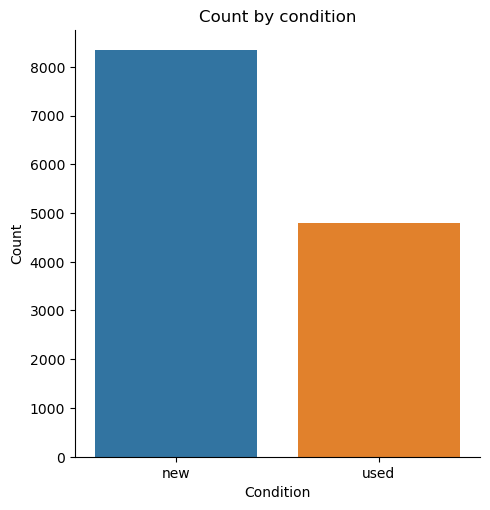

In [40]:
sns.catplot(
    data= data,
    x='condition',
    kind='count',
)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Count by condition')
plt.show()

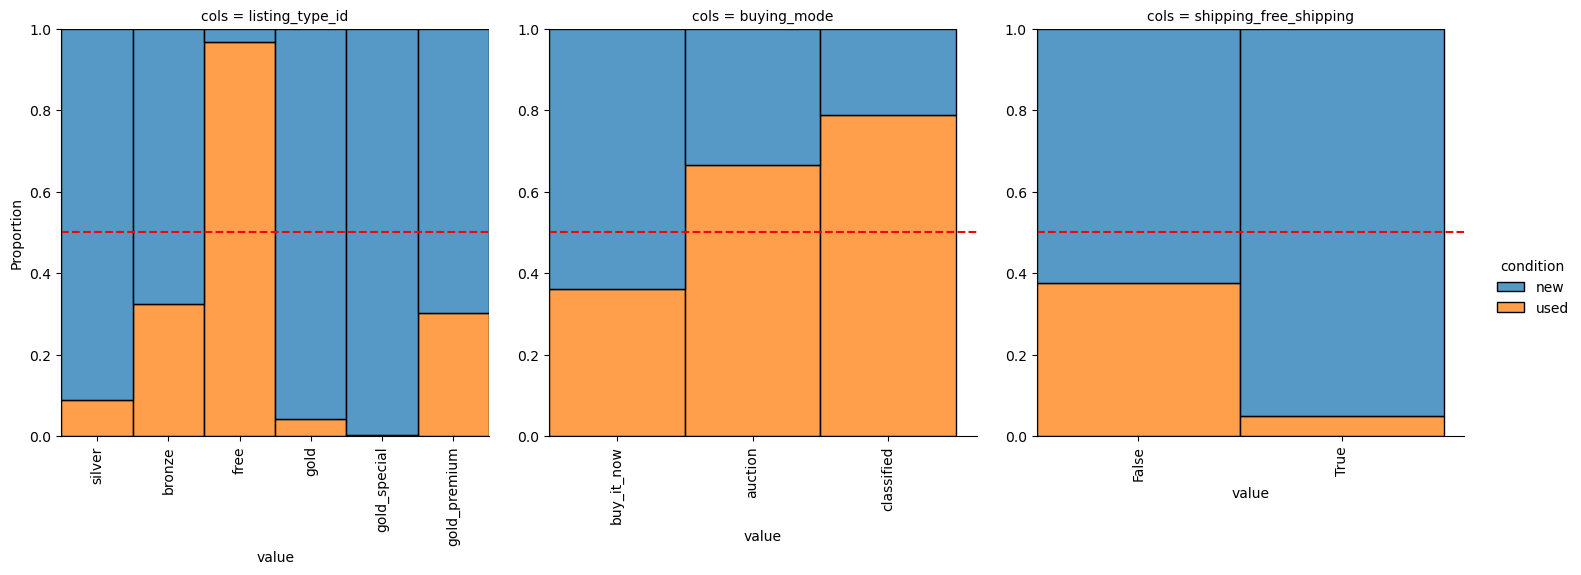

In [41]:
cols = ['listing_type_id', 'buying_mode', 'shipping_free_shipping', 'condition']

data_melt= data[cols].melt(id_vars='condition', var_name='cols')
g = sns.displot(
    data=data_melt,
    x='value',
    col='cols',
    hue='condition',
    multiple='fill',
    stat='proportion',
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.axhline(y=0.5, color='red', linestyle='--')

with this graph we seek to see the relationship between the condition of the items, the type of shipping, type of purchase and the type of list to see what proportions they have, resulting in classes such as free of list type, classified and without free shipping having greater weight for the variable used.